In [52]:
import os
import os.path as osp
import argparse as arp
from typing import Dict,Callable,List

import pandas as pd
import numpy as np
import torch as t
import torch.distributions as dists

In [53]:
sc_cnt_pth="scdata/CID44971/scdata_cut_5types2.csv" 
sc_lbl_pth="scdata/CID44971/metadata_cut_5types2.csv"
#sig="data/tnbc_signature.csv"  # Signature gene sets for GSVA calculation

# Output file paths
#exp="scdata/counts.st_synth.csv" # output ST expression
#gs_path="scdata/"
#gs="marker_gsva_bc.csv" # output ST GSVA scores

# Input parameters
n_spots=2551
n_genes=29733

In [55]:
## load data

sc_cnt = pd.read_csv(sc_cnt_pth,
                         sep = ',',
                         index_col = 0,
                         header = 0)
sc_lbl = pd.read_csv(sc_lbl_pth,
                         sep = ',',
                         index_col = 0,
                         header = 0)

inter = sc_cnt.index.intersection(sc_lbl.index)
sc_lbl = sc_lbl.loc[inter,:]
sc_cnt = sc_cnt.loc[inter,:]

In [56]:
sc_lbl

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,subtype,celltype_subset,celltype_minor,celltype_major
CID44971_AAACGGGTCCCAACGG,CID44971,5449,2036,5.193614,TNBC,CAFs MSC iCAF-like s1,CAFs MSC iCAF-like,CAFs
CID44971_AACTGGTCACGCCAGT,CID44971,25501,4391,2.760676,TNBC,CAFs MSC iCAF-like s1,CAFs MSC iCAF-like,CAFs
CID44971_AAGCCGCAGGGTTTCT,CID44971,7551,2406,2.397034,TNBC,CAFs MSC iCAF-like s1,CAFs MSC iCAF-like,CAFs
CID44971_AAGGTTCCAATGAAAC,CID44971,5615,2102,3.811220,TNBC,CAFs MSC iCAF-like s1,CAFs MSC iCAF-like,CAFs
CID44971_AAGTCTGAGCCAGAAC,CID44971,5459,1921,3.132442,TNBC,CAFs MSC iCAF-like s1,CAFs MSC iCAF-like,CAFs
...,...,...,...,...,...,...,...,...
CID44971_TTGACTTTCTCTTATG,CID44971,8104,2556,15.621915,TNBC,Mature Luminal,Mature Luminal,Normal Epithelial
CID44971_TTGGCAAGTTCGTCTC,CID44971,9533,2747,5.696003,TNBC,Mature Luminal,Mature Luminal,Normal Epithelial
CID44971_TTTATGCTCAGATAAG,CID44971,30710,5676,6.984696,TNBC,Mature Luminal,Mature Luminal,Normal Epithelial
CID44971_TTTCCTCCAAGCCATT,CID44971,6997,2560,5.473774,TNBC,Mature Luminal,Mature Luminal,Normal Epithelial


In [57]:
sc_lbl.loc[:,'nCount_RNA'].min()

416

(array([5.663e+03, 5.830e+02, 2.660e+02, 1.700e+02, 1.160e+02, 8.400e+01,
        3.600e+01, 1.700e+01, 9.000e+00, 2.000e+00]),
 array([  416.,  7964., 15512., 23060., 30608., 38156., 45704., 53252.,
        60800., 68348., 75896.]),
 <BarContainer object of 10 artists>)

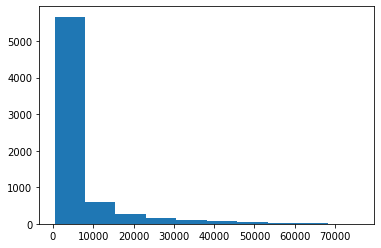

In [58]:
import matplotlib.pyplot as plt
plt.hist(sc_lbl.loc[:,'nCount_RNA'])

In [59]:
import scanpy as sc
import anndata

adata = anndata.AnnData(sc_cnt)
adata.obs = sc_lbl

In [60]:
adata = adata[adata.obs['percent.mito']<5]

In [61]:
adata = adata[(adata.obs['nCount_RNA']>2000) &(adata.obs['nCount_RNA']<20000) ]

In [62]:
from semiVAE import get_gsva,utils,data_loader,poe_trainer,sigvae_trainer,poe_model,get_recon,sigvae_model,plot_utils, postprocess
adata_sample_processed = utils.preprocess(adata, n_top_genes=2000) 
adata = adata[:,adata_sample_processed.var_names]
adata.var = adata_sample_processed.var
adata.obs = adata_sample_processed.obs

Preprocessing1: delete the mt and rp
Preprocessing2: Normalize


/usr/local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing3: Logarithm
Preprocessing4: Find the variable genes


In [63]:
sc.tl.pca(adata_sample_processed, svd_solver='arpack')
sc.pp.neighbors(adata_sample_processed, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_sample_processed)

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'subtype' as categorical
/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Cat

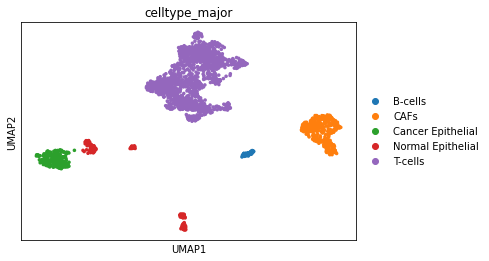

In [64]:
sc.pl.umap(adata_sample_processed,color='celltype_major')

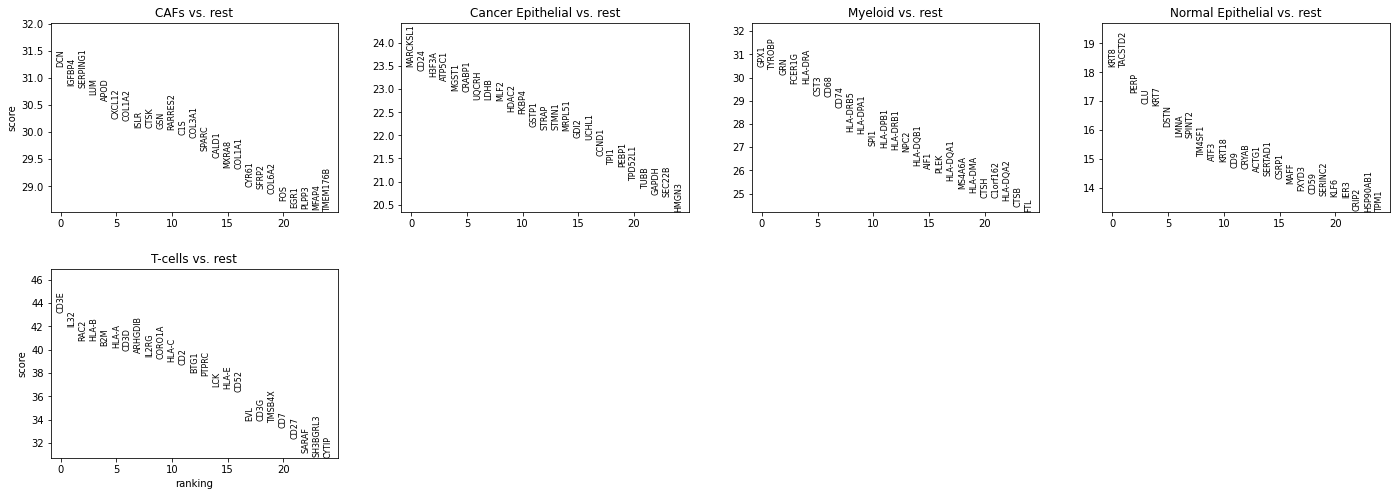

In [39]:
sc.tl.rank_genes_groups(adata_sample_processed, 'celltype_major', method='wilcoxon')
sc.pl.rank_genes_groups(adata_sample_processed, n_genes=25, sharey=False)

In [40]:
pd.DataFrame(adata_sample_processed.uns['rank_genes_groups']['names']).head(20)

,CAFs,Cancer Epithelial,Myeloid,Normal Epithelial,T-cells
0,DCN,MARCKSL1,GPX1,KRT8,CD3E
1,IGFBP4,CD24,TYROBP,TACSTD2,IL32
2,SERPING1,H3F3A,GRN,PERP,RAC2
3,LUM,ATP5C1,FCER1G,CLU,HLA-B
4,APOD,MGST1,HLA-DRA,KRT7,B2M
5,CXCL12,CRABP1,CST3,DSTN,HLA-A
6,COL1A2,UQCRH,CD68,LMNA,CD3D
7,ISLR,LDHB,CD74,SPINT2,ARHGDIB
8,CTSK,MLF2,HLA-DRB5,TM4SF1,IL2RG
9,GSN,HDAC2,HLA-DPA1,ATF3,CORO1A


In [41]:
pd.DataFrame(adata_sample_processed.uns['rank_genes_groups']['names']).head(20).to_csv('simu_data/simu_3/marker.csv')

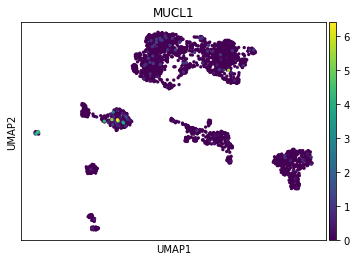

In [42]:
sc.pl.umap(adata_sample_processed,color='MUCL1')

In [65]:
sc.pp.normalize_total(adata, inplace=True) 

In [68]:
sc_cnt.sum(axis=1)

CID44971_AAGCCGCAGGGTTTCT    2535.0
CID44971_AAGGTTCCAATGAAAC    2535.0
CID44971_AAGTCTGAGCCAGAAC    2535.0
CID44971_ACACCAATCAGCTCGG    2535.0
CID44971_ACATCAGCACTATCTT    2535.0
                              ...  
CID44971_GGGAATGGTCTAGCGC    2535.0
CID44971_GGGTTGCGTGGTCTCG    2535.0
CID44971_TCGAGGCAGCTACCTA    2535.0
CID44971_TCGTAGAGTTAAAGTG    2535.0
CID44971_TTCTACATCGAATGCT    2535.0
Length: 2375, dtype: float32

In [67]:
sc_cnt = adata.to_df()
sc_lbl = adata.obs

In [69]:
def assemble_data_set(cnt : pd.DataFrame,
                      labels : pd.DataFrame,
                      n_spots : int,
                      n_genes : int,
                      n_cell_range : List[int],
                      assemble_fun : Callable = _assemble_spot,
                     )-> Dict[str,pd.DataFrame]:

    """Assemble Synthetic ST Data Set
    Assemble synthetic ST Data Set from
    a provided single cell data set
    Parameters:
    ----------
    cnt : pd.DataFrame
        single cell count data
    labels : pd.DataFrame
        single cell annotations
    n_spots : int
        number of spots to generate
    n_genes : int
        number of gens to include
    assemble_fun : Callable
        function to assemble single spot
    """

    # get labels
    # labels = labels.loc[:,'bio_celltype']
    labels = labels.loc[:, 'celltype_major']

    # make sure number of genes does not
    # exceed number of genes present
    n_genes = np.min((cnt.shape[1],n_genes))
    # select top expressed genes
    keep_genes = np.argsort(cnt.sum(axis=0))[::-1]
    keep_genes = keep_genes[0:n_genes]
    cnt = cnt.iloc[:,keep_genes]

    # get unique labels
    uni_labels = np.unique(labels.values)
    n_labels = uni_labels.shape[0]

    # prepare matrices
    st_cnt = np.zeros((n_spots,cnt.shape[1]))
    st_prop = np.zeros((n_spots,n_labels))
    st_memb = np.zeros((n_spots,n_labels))

    np.random.seed(1337)
    t.manual_seed(1337)
    # generate one spot at a time
    for spot in range(n_spots):
        spot_data = assemble_fun(cnt.values,
                                 labels.values,
                                 bounds = n_cell_range,
                                 )

        st_cnt[spot,:] = spot_data['expr']
        st_prop[spot,:] = spot_data['proportions']
        st_memb[spot,:] =  spot_data['members']

        index = pd.Index(['Spotx' + str(x + 1) for \
                          x in range(n_spots) ])

    # convert to pandas DataFrames
    st_cnt = pd.DataFrame(st_cnt,
                          index = index,
                          columns = cnt.columns,
                         )

    st_prop = pd.DataFrame(st_prop,
                           index = index,
                           columns = uni_labels,
                          )
    st_memb = pd.DataFrame(st_memb,
                           index = index,
                           columns = uni_labels,
                           )


    return {'counts':st_cnt,
            'proportions':st_prop,
            'members':st_memb}

In [70]:
def _assemble_spot(cnt : np.ndarray,
                  labels : np.ndarray,
                  alpha : float = 1.0,
                  fraction : float = 0.1,
                  bounds : List[int] = [5, 15],
                  )->Dict[str,t.Tensor]:

    """Assemble single spot
    generates one synthetic ST-spot
    from provided single cell data
    Parameter:
    ---------
    cnt : np.ndarray
        single cell count data [n_cells x n_genes]
    labels : np.ndarray
        single cell annotations [n_cells]
    alpha : float
        dirichlet distribution
        concentration value
    fraction : float
        fraction of transcripts from each cell
        being observed in ST-spot
    Returns:
    -------
    Dictionary with expression data,
    proportion values and number of
    cells from each type at every
    spot
    """

    # sample between 10 to 30 cells to be present
    # at spot
    n_cells = dists.uniform.Uniform(low = bounds[0],
                                    high = bounds[1]).sample().round().type(t.int)

    # get unique labels found in single cell data
    uni_labs, uni_counts = np.unique(labels,
                                     return_counts = True)

    # make sure sufficient number
    # of cells are present within
    # all cell types
    assert np.all(uni_counts >=  bounds[-1]), \
            "Insufficient number of cells"

    # get number of different
    # cell types present
    n_labels = uni_labs.shape[0]

    # sample number of types to
    # be present at current spot
    #print('n_labels=',n_labels)
    n_types = dists.uniform.Uniform(low = 1,
                                    high =  n_labels).sample()

    n_types = n_types.round().type(t.int)

    # select which types to include
    pick_types = t.randperm(n_labels)[0:n_types]
    # pick at least one cell for spot
    members = t.zeros(n_labels).type(t.float)
    while members.sum() < 1:
        # draw proportion values from probability simplex
        member_props = dists.Dirichlet(concentration = alpha * t.ones(n_types)).sample()
        # get integer number of cells based on proportions
        members[pick_types] = (n_cells * member_props).round()

    # get proportion of each type
    props = members / members.sum()
    # convert to ints
    members = members.type(t.int)
    # get number of cells from each cell type

    # generate spot expression data
    spot_expr = t.zeros(cnt.shape[1]).type(t.float32)

    for z in range(n_types):
        # get indices of selected type
        idx = np.where(labels == uni_labs[pick_types[z]])[0]
        # pick random cells from type
        np.random.shuffle(idx)
        idx = idx[0:members[pick_types[z]]]
        # add fraction of transcripts to spot expression
        spot_expr +=  t.tensor((cnt[idx,:]*fraction).sum(axis = 0).round().astype(np.float32))


    return {'expr':spot_expr,
            'proportions':props,
            'members': members,
           }

In [71]:
n_cell_range = [5,15]
tag = 'st_synth'

In [72]:
out_dir = "simu_data/simu_6/"

In [73]:
assembled_set = assemble_data_set(sc_cnt,
                                      sc_lbl,
                                      n_spots = n_spots,
                                      n_genes = n_genes,
                                      n_cell_range = n_cell_range,
                                      assemble_fun = _assemble_spot,
                                      )

    # Save output as csv
for k,v in assembled_set.items() :
        out_pth = osp.join(out_dir, '.'.join([k,tag,'csv']))
        v.to_csv(out_pth,
                    sep = ',',
                    index = True,
                    header = True,
                   )